![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt



In [4]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [5]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [6]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [25]:
print(dataTraining.shape)
display(dataTraining.head(2))
print(dataTesting.shape)
display(dataTesting.head(2))

(7895, 5)


,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"[Short, Drama]",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"[Comedy, Crime, Horror]",5.6


(3383, 3)


,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."


In [26]:
7895+3383

11278

## Analisis Exploratorio de Datos

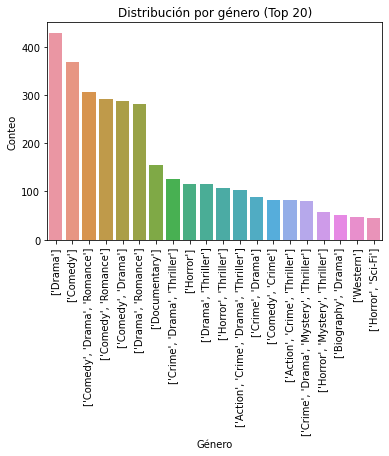

In [16]:
# Contar los géneros y obtener el top 5
top_genres = dataTraining['genres'].value_counts().head(20)

# Crear el gráfico de barras con el top 5
sns.countplot(x="genres", data=dataTraining, order=top_genres.index)

# Personalizar el gráfico
plt.title("Distribución por género (Top 20)")
plt.xlabel("Género")
plt.ylabel("Conteo")

# Rotar las etiquetas del eje x para una mejor legibilidad
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.show()

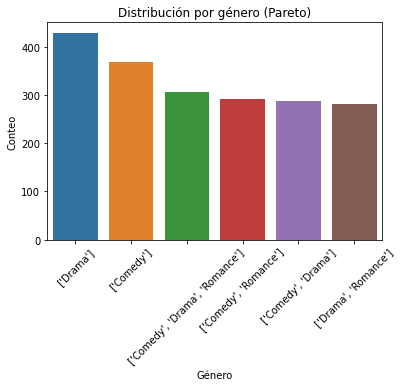

In [15]:
# Contar los géneros y obtener el top 5 por conteo
genre_counts = dataTraining['genres'].value_counts()
total_count = genre_counts.sum()
cumulative_percentage = genre_counts.cumsum() / total_count

# Filtrar los géneros más significativos (hasta el 80% del total)
significant_genres = genre_counts[cumulative_percentage <= 0.25]

# Crear el gráfico de barras con los géneros más significativos
sns.countplot(x="genres", data=dataTraining, order=significant_genres.index)

# Personalizar el gráfico
plt.title("Distribución por género (Pareto)")
plt.xlabel("Género")
plt.ylabel("Conteo")

# Rotar las etiquetas del eje x para una mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

In [17]:
dataTraining["genres"] = dataTraining['genres'].map(lambda x: eval(x))

,index,0
0,Drama,3965
1,Comedy,3046
2,Thriller,2024
3,Romance,1892
4,Crime,1447
5,Action,1303
6,Adventure,1024
7,Horror,954
8,Mystery,759
9,Sci-Fi,723


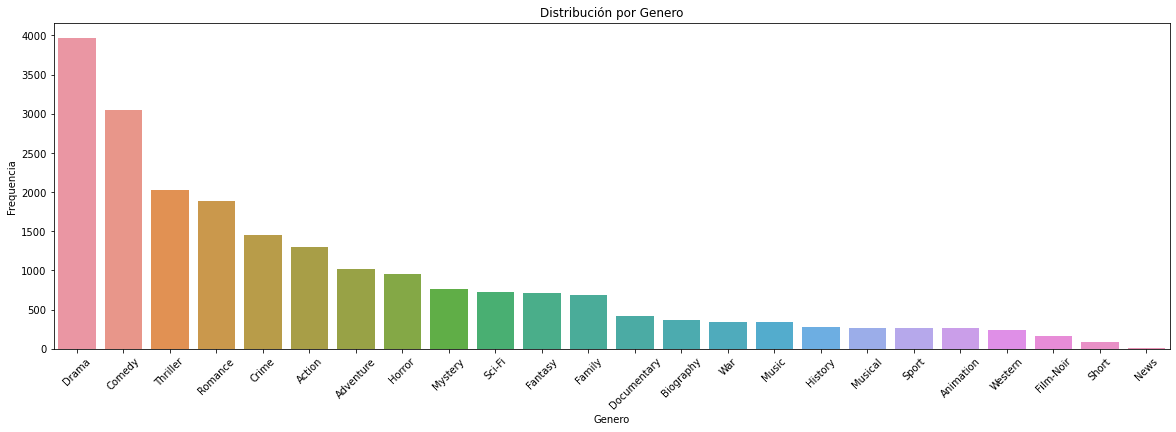

In [21]:
genre_count = pd.DataFrame(pd.value_counts([x for row in dataTraining["genres"].values.tolist() for x in row ])).reset_index()

display(genre_count)
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data=genre_count, x="index", y= 0)
plt.title('Distribución por Genero')
plt.xlabel('Genero')
plt.ylabel('Frequencia')
plt.xticks(rotation = 45);

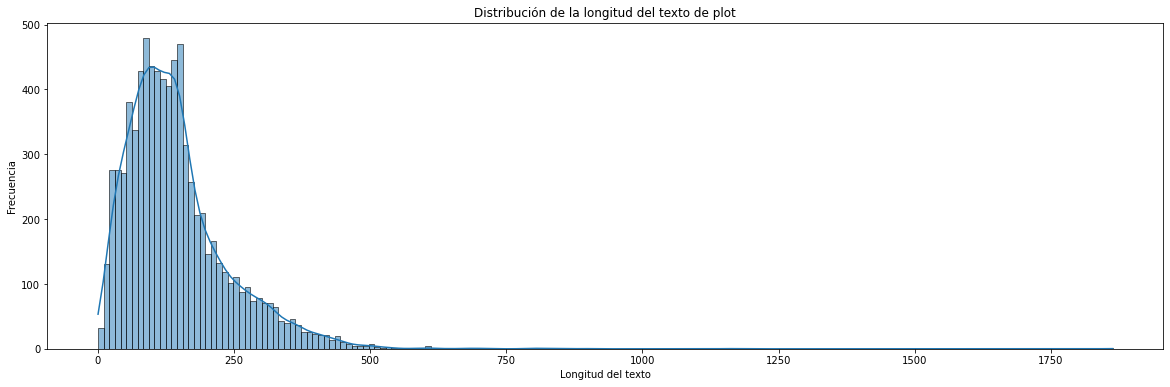

In [30]:
# Calcular la longitud del texto de trama
dataTraining['plot_length'] = dataTraining['plot'].apply(lambda x: len(x.split()))

# Analizar la distribución de la longitud del texto
fig, ax = plt.subplots(figsize=(20,6))

sns.histplot(data=dataTraining, x='plot_length', kde=True)

# Personalizar el gráfico
plt.title("Distribución de la longitud del texto de plot")
plt.xlabel("Longitud del texto")
plt.ylabel("Frecuencia")

# Mostrar el gráfico
plt.show()

In [50]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# Descargar las stopwords en caso de no tenerlas
nltk.download('stopwords')

# Obtener las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Crear una instancia de CountVectorizer con las stopwords
vectorizer = CountVectorizer(stop_words=stop_words)

# Tokenizar y contar la frecuencia de las palabras en los textos de trama
plot_text = dataTraining['plot'].values
plot_matrix = vectorizer.fit_transform(plot_text)

# Obtener la lista de palabras clave sin las stopwords
feature_names = vectorizer.get_feature_names()

# Calcular la frecuencia de las palabras clave
word_frequency = plot_matrix.sum(axis=0)

# Crear un DataFrame para visualizar las palabras clave y su frecuencia
keyword_df = pd.DataFrame({'Palabra clave': feature_names, 'Frecuencia': word_frequency.flat})
keyword_df = keyword_df.sort_values(by='Frecuencia', ascending=False)

# Mostrar las 10 palabras clave más frecuentes
top_keywords = keyword_df.head(20)
print(top_keywords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


      Palabra clave  Frecuencia
24236           one        3010
19915          life        2721
23512           new        2255
20967           man        1927
35652           two        1728
14049           get        1713
12189        family        1599
20411          love        1530
12672          find        1457
12322        father        1454
34707          time        1433
38307         young        1356
918            also        1311
24176           old        1249
12676         finds        1243
38045         world        1211
2279           back        1210
38244         years        1201
13466        friend        1189
37713          wife        1173


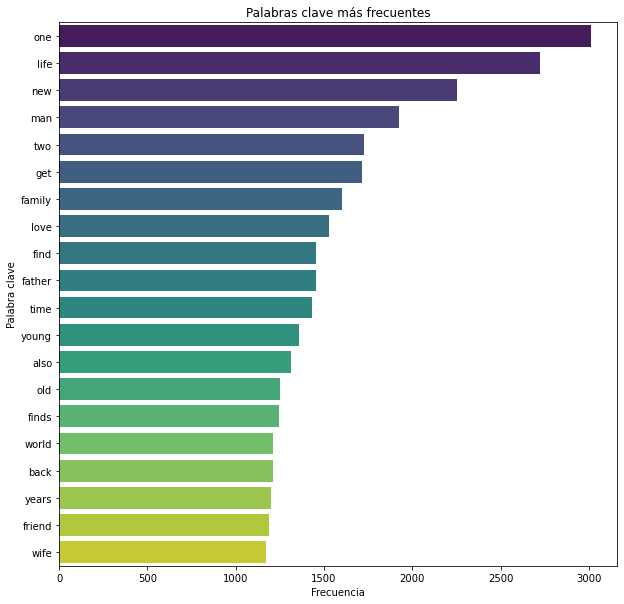

In [52]:
# Crear el gráfico de barras utilizando seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='Frecuencia', y='Palabra clave', data=top_keywords, palette='viridis')

# Personalizar el gráfico
plt.title("Palabras clave más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra clave")

# Mostrar el gráfico
plt.show()

In [42]:
def preprocesamiento(texto):
    procesado = texto.lower()
    procesado = re.sub(r"[^a-zÑñ\s]","",procesado)
    procesado = unidecode(procesado)
    procesado = re.sub(r"\s+"," ",procesado)
    
    wordnet_lemmatizer = WordNetLemmatizer()
    procesado = [wordnet_lemmatizer.lemmatize(i, pos="v") for i in procesado.split() if len(i)>2 and i not in stopwords.words("english")] #lematizar verbos
    procesado = " ".join(procesado)
    procesado = [wordnet_lemmatizer.lemmatize(i, pos="n") for i in procesado.split()] #Plurales
    # " ".join(procesado)
    return procesado

     ---------------------------------------- 2.5/2.5 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.0
    Uninstalling Pillow-9.0.0:
      Successfully uninstalled Pillow-9.0.0


ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\Felipe\\anaconda3\\envs\\Financiero\\Lib\\site-packages\\~-l\\_imaging.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



## Preprocesamiento de datos

In [7]:
# Creación de matrices de documentos usando CountVectorizer a partir de X y usando n-gramas
vect_C = CountVectorizer(lowercase=False, ngram_range=(1, 4))
X_dtm_C = vect_C.fit_transform(dataTraining['plot'])

In [8]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [9]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm_C, y_genres, test_size=0.33, random_state=42)

## Modelado

In [10]:
# Definición y entrenamiento
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10, n_jobs=-1,
                                                     random_state=42))

In [11]:
# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7179887449936283

In [13]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = vect_C.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [14]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.157372,0.120590,0.024426,0.039439,0.386693,0.171099,0.047538,0.501982,0.073919,0.080033,...,0.027121,0.089671,0.000331,0.246983,0.080196,0.008054,0.025661,0.245530,0.03916,0.022843
4,0.153889,0.119420,0.024426,0.049008,0.369359,0.177844,0.050020,0.505373,0.083209,0.080033,...,0.027121,0.088811,0.000470,0.219525,0.080196,0.007995,0.025661,0.246233,0.03916,0.022843
5,0.170551,0.121299,0.024426,0.049053,0.344137,0.251218,0.055414,0.534546,0.075315,0.080033,...,0.027121,0.106930,0.000173,0.248832,0.080466,0.008159,0.025661,0.271242,0.03916,0.022843
6,0.162694,0.120987,0.024426,0.039439,0.377795,0.174027,0.047113,0.522424,0.073919,0.080033,...,0.027121,0.091144,0.000235,0.251938,0.080655,0.007999,0.025661,0.267840,0.03991,0.022843
7,0.157076,0.124614,0.024426,0.039439,0.367394,0.181023,0.047064,0.495541,0.073919,0.084919,...,0.027121,0.105109,0.000208,0.234537,0.101630,0.008054,0.025661,0.251644,0.03916,0.022843
